# [book](https://nbviewer.org/github/fastai/fastbook/blob/master/12_nlp_dive.ipynb)

In [90]:
dependencies = [
    "fastai",
    "nbdev",
    "datasets"
]

!pip install -U {" ".join(dependencies)}

from fastai.imports import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.6 MB/s eta 0:00:00-:--:--
  Attempting uninstall: nbdev
    Found existing installation: nbdev 2.3.20
    Uninstalling nbdev-2.3.20:
      Successfully uninstalled nbdev-2.3.20


In [91]:
from fastai.imports import *
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)
Path.BASE_PATH = path
path.ls()

(#2) [Path('train.txt'),Path('valid.txt')]

# Helpers

In [92]:
import pandas as pd

results_df = pd.DataFrame(columns=[''])

def track_results(experiment_name, result, reset=False):
    global results_df
    if reset:
        results_df = pd.DataFrame(columns=[''])
    if hasattr(result, '__dict__') and '__str__' in result.__dict__:
        results_df.loc[experiment_name] = result
    else:
        results_df.loc[experiment_name] = repr(result)
    return results_df

In [93]:
import torch
import gc

def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [94]:
def get_device_type():
    return 'cpu' if 'darwin' in platform.system().lower() else 'cuda'

In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Preprocessing

In [96]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [97]:
text = ' . '.join([l.strip() for l in lines])
len(text), text[:100]

(365478,
 'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo')

### Tokenize

In [98]:
# tokenize
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

### Numericalize

In [99]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [100]:
# numericalize
def my_numericalize(tokens):
    word2idx = {w:i for i,w in enumerate(vocab)}
    return L(word2idx[i] for i in tokens)
nums = my_numericalize(tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

# DataLoader for new Task -  Predicting The 4th Word

### Independent and Dependent Variable

In [101]:
# independent variables = 3 tokens
# dependent variable = 4th token

L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [102]:
# numericalize
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

### DataLoader

In [103]:
bs = 64
split = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:split], seqs[split:], bs=64, shuffle=False)
explode_types(dls.one_batch())

{tuple: [torch.Tensor, torch.Tensor]}

### Fixing `show_batch()`

In [104]:
# we need to create a new version of show_batch
# that knows how to handle our new type
@typedispatch
def show_batch(x:(Tensor,Tensor), y, samples, ctxs=None, max_n=10, trunc_at=150, **kwargs):
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    for i,ctx in enumerate(ctxs):
        ctx['text'] = ' '.join([vocab[o] for o in samples[i][0]])
        ctx['target'] = vocab[samples[i][1]]
        if i == max_n: break
    display_df(pd.DataFrame(ctxs))

dls.show_batch(max_n=5)

,text,target
0,one . two,.
1,. three .,four
2,four . five,.
3,. six .,seven
4,seven . eight,.


# RNN Basics

### PyTorch Model Module

In [105]:
emb = nn.Embedding(len(vocab), 50)
emb

Embedding(30, 50)

In [106]:
train_x, train_y = dls.one_batch()
train_x.shape, train_y.shape

(torch.Size([64, 3]), torch.Size([64]))

In [107]:
emb(train_x).shape

torch.Size([64, 3, 50])

In [108]:
train_x[:,0].shape

torch.Size([64])

In [116]:
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        # embedding layer for input -> embedding
        self.input_to_embed = nn.Embedding(vocab_sz, n_hidden) # out=number of latent factors

        # next word activation
        self.embed_to_hidden = nn.Linear(n_hidden, n_hidden) # out=number of hidden

        # final layer to predict the well.. the final thing
        self.hidden_to_output = nn.Linear(n_hidden, vocab_sz) # out=number of classes

    def forward(self, x):        
        # let's just focus on one single row (same logic for the 64 items of the batch)

        # FOR THE FIRST TOKEN
        # 1. create embedding for 1st token
        first_tok_embed = self.input_to_embed(x[:,0])
        # 2. feed the embedding to the hidden layer,
        # (when we move from layer to layer we want a ReLU)
        h = F.relu(self.embed_to_hidden(first_tok_embed))
        print(h.shape)

        # FOR THE SECOND TOKEN
        # 1. concatenate the 1st layer's activation + 2nd token embedding 
        h = h + self.input_to_embed(x[:,1])
        # 2. feed that to the hidden layer
        h = F.relu(self.embed_to_hidden(h))
        print(h.shape)

        # FOR THE THIRD WORD
        # 1. concatenate the 2nd layer's activation + 3rd token embedding
        h = h + self.input_to_embed(x[:,2])

        # 2. feed that to the hidden layer
        h = F.relu(self.embed_to_hidden(h))
        print(h.shape)

        # Finally, we feed that whole thing to the output layer    
        return self.hidden_to_output(h)
    
model = LMModel1(len(vocab), 50)
model
        

LMModel1(
  (input_to_embed): Embedding(30, 50)
  (embed_to_hidden): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=30, bias=True)
)

Important thing to notice here, is that in the forward pass, all layers work with the _same weight matrix_

In [117]:
model(train_x).shape

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])


torch.Size([64, 30])

In [110]:
learn = Learner(dls, model, loss_func=F.cross_entropy, 
                metrics=accuracy)
print(learn.model)
learn.fit_one_cycle(4, 1e-3)

LMModel1(
  (input_to_embed): Embedding(30, 50)
  (embed_to_hidden): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=30, bias=True)
)


epoch,train_loss,valid_loss,accuracy,time
0,1.962035,1.991906,0.467792,00:00
1,1.419731,1.764018,0.482529,00:00
2,1.403957,1.687602,0.493701,00:00
3,1.371382,1.650378,0.484431,00:00


torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

epoch,train_loss,valid_loss,accuracy,time
0,1.998725,1.954713,0.459948,00:08
1,1.446180,1.811411,0.467792,00:08
2,1.453498,1.674811,0.486095,00:08
3,1.409633,1.659829,0.488947,00:08


is it bad or good accuracy? Let's check what a model, that predict us the most common token, would give us as accuracy

In [22]:
n,counts = 0,torch.zeros(len(vocab))
for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()
idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(29), 'thousand', 0.15165200855716662)

that's 15%, so we are doing way better!

### RNN - The Same Model But With A Loop

In [23]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.input_to_embed = nn.Embedding(vocab_sz, n_hidden)  
        self.embed_to_hidden = nn.Linear(n_hidden, n_hidden)     
        self.hidden_to_output = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        # we don't need this but just to make it explicity
        # that h is reinitialized at every call to forward()
        h = 0

        # the loop here represent not the layers
        # but the number of tokens in the sequence
        for i in range(3):
            
            h = h + self.input_to_embed(x[:,i])
            h = F.relu(self.embed_to_hidden(h))
        return self.hidden_to_output(h)
    
model = LMModel2(len(vocab), 50)
model

LMModel2(
  (input_to_embed): Embedding(30, 50)
  (embed_to_hidden): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=30, bias=True)
)

In [25]:
learn = Learner(dls, model, loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.988599,1.935852,0.458997,00:08
1,1.460923,1.794153,0.465890,00:10
2,1.438169,1.711949,0.484668,00:14
3,1.400839,1.725397,0.445448,00:25


In [128]:
track_results('LMModel2 - stateless', learn.recorder.log[-2], reset=True)

,
LMModel2 - stateless,0.4361777901649475


# Improving the RNN

What's going on? Look at forward pass:
```python
 def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.input_to_embed(x[:,i])
            h = F.relu(self.embed_to_hidden(h))
        return self.hidden_to_output(h)
```

__Problem1: h is reinitialized__
- h is reinitialized to 0 every time

__Problem2:__
- why only predict the 4th word when we could use the intermediate predictions to also predict the 2nd and 3rd word?

Let's see how to implement those changes

### Maintaining the State of an RNN

In [41]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.input_to_embed = nn.Embedding(vocab_sz, n_hidden)  
        self.embed_to_hidden = nn.Linear(n_hidden, n_hidden)     
        self.hidden_to_output = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.input_to_embed(x[:,i])
            self.h = F.relu(self.embed_to_hidden(self.h))
        output = self.hidden_to_output(self.h)
        self.h = self.h.detach()
        return output
    
    def reset(self): self.h = 0

model = LMModel3(len(vocab), 50)
model

LMModel3(
  (input_to_embed): Embedding(30, 50)
  (embed_to_hidden): Linear(in_features=50, out_features=50, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=30, bias=True)
)

what does the state of the model represent?

In [39]:
train_x.device

device(type='cpu')

In [42]:
# r = model(train_x)
# model.h.shape, model.h

what does the result of forward() represents?

why is the result of forward() and model.h different? what do each represent?

### Chaining Chunks Properly

In [30]:
# just some debug helpers
def num_to_vocab(tns):
    if tns.dim() == 0:
        return vocab[tns.item()]
    else:
        return [vocab[o] for o in tns]

def debug_tuple_batch(samples, max_n=3):
    bs = len(samples[0])
    ctxs = get_empty_df(min(bs, max_n))
    for i,ctx in enumerate(ctxs):
        ctx['text'] = ' '.join([vocab[o] for o in samples[0][i]])
        ctx['target'] = vocab[samples[1][i]]
        if i == max_n: break
    display_df(pd.DataFrame(ctxs))

def debug_two_batches(dataset):
    iter_dls = iter(dataset)
    first_batch = next(iter_dls)
    second_batch = next(iter_dls)

    debug_tuple_batch(first_batch)
    debug_tuple_batch(second_batch)

__Let's recap how we are feeding data to the model__

In [31]:
debug_two_batches(dls.train)

,text,target
0,one . two,.
1,. three .,four
2,four . five,.


,text,target
0,three . seventy,four
1,four . seventy,five
2,five . seventy,six


__What's wrong?__
Remember that we are now keeping a state for each row, so we want the next batch to start from where it was before:
- batch 1 row 1 -> batch 2 row 1
- batch 1 row 2 -> batch 2 row 2
- etc.

In [32]:
bs = 64
split = int(len(seqs) * 0.8)

In [33]:
m = len(seqs)//bs
m,bs,len(seqs)

def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

group_chunks(seqs[:split], bs)

(#16768) [(tensor([0, 1, 2]), 1),(tensor([11,  1,  2]), 28),(tensor([25,  7,  1]), 3),(tensor([5, 1, 5]), 28),(tensor([28, 12,  1]), 7),(tensor([ 8, 28, 25]), 8),(tensor([29, 22,  6]), 1),(tensor([28, 25,  8]), 1),(tensor([29,  2, 28]), 27),(tensor([13,  1,  0]), 29)...]

In [35]:
# one last thing is to call drop_last = True, because last chunk might not be long enough
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:split], bs), 
    group_chunks(seqs[split:], bs),
    bs=bs, drop_last=True, shuffle=False)

debug_two_batches(dls.train)

,text,target
0,one . two,.
1,eleven . two,hundred
2,seventy seven .,three


,text,target
0,. three .,four
1,hundred twelve .,two
2,three hundred seventy,eight


In [43]:
# The last thing we add is a little tweak of the training loop via a Callback.
# this one will call the reset method of our model at the beginning of each epoch and before each validation phase.
#
# Since we implemented that method to zero the hidden state of the model,
# this will make sure we start with a clean state before reading those continuous chunks of text.
# We can also start training a bit longer:
learn = Learner(dls, model, loss_func=F.cross_entropy,
                metrics=accuracy, cbs=[ModelResetter,ActivationStats(with_hist=True)])
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.791531,1.941288,0.450000,00:12
1,1.358283,1.885019,0.394712,00:12
2,1.115887,1.770902,0.437740,00:12
3,1.032673,1.537765,0.519712,00:13
4,0.971527,1.452277,0.566587,00:13
5,0.938112,1.632869,0.537260,00:11
6,0.877660,1.576912,0.581010,00:13
7,0.835049,1.544586,0.592548,00:11
8,0.802555,1.573149,0.590144,00:12
9,0.790295,1.589208,0.590865,00:12


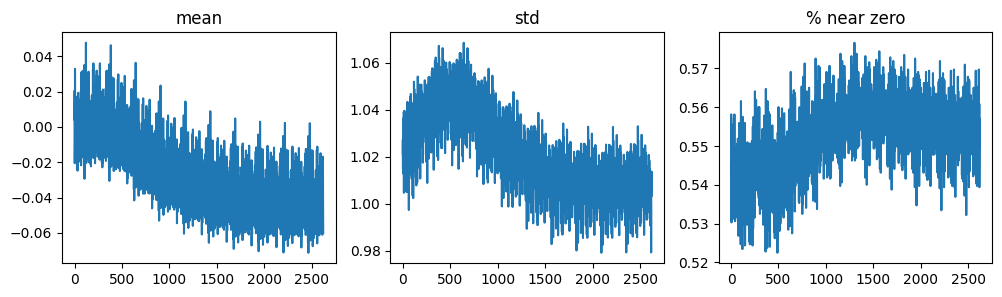

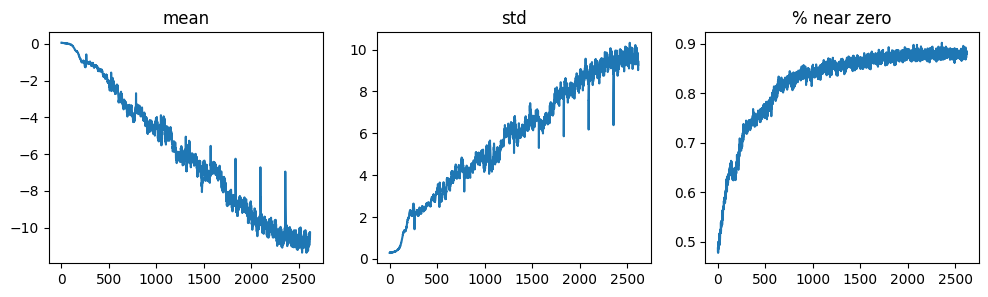

In [45]:
learn.activation_stats.plot_layer_stats(0)
learn.activation_stats.color_dim(0)
learn.activation_stats.plot_layer_stats(-1)
learn.activation_stats.color_dim(-1)

In [46]:
track_results('LMModel3 - Stateful RNN', learn.recorder.log[-2])

,
LMModel3 - Stateful RNN,0.5908653736114502


### Creating More Signal To Get To The Point Of Overfitting

The first rule of training, is always to get to a point where you overfit.

We are still not overfitting, meaning we need to ask more, we need to ask something harder from our model.
> In terms of optimization, it means there is not enough feeding back enough signal to update weights.

Instead of asking to predict every 4th word, let's ask it to predict the next word. 

In [47]:
# preparing x and y
sequence_length = 16
seqs = L((tensor(nums[i:i+sequence_length]), tensor(nums[i+1:i+sequence_length+1]))
         for i in range(0,len(nums)-sequence_length-1,sequence_length))

split = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:split], bs),
                             group_chunks(seqs[split:], bs),
                             bs=bs, drop_last=True, shuffle=False)
dls.vocab = vocab

debug_two_batches(dls.train)

,text,target
0,one . two . three . four . five . six . seven . eight .,"[., two, ., three, ., four, ., five, ., six, ., seven, ., eight, ., nine]"
1,two hundred eleven . two hundred twelve . two hundred thirteen . two hundred fourteen .,"[hundred, eleven, ., two, hundred, twelve, ., two, hundred, thirteen, ., two, hundred, fourteen, ., two]"
2,six . three hundred seventy seven . three hundred seventy eight . three hundred seventy nine,"[., three, hundred, seventy, seven, ., three, hundred, seventy, eight, ., three, hundred, seventy, nine, .]"


,text,target
0,nine . ten . eleven . twelve . thirteen . fourteen . fifteen . sixteen .,"[., ten, ., eleven, ., twelve, ., thirteen, ., fourteen, ., fifteen, ., sixteen, ., seventeen]"
1,two hundred fifteen . two hundred sixteen . two hundred seventeen . two hundred eighteen .,"[hundred, fifteen, ., two, hundred, sixteen, ., two, hundred, seventeen, ., two, hundred, eighteen, ., two]"
2,. three hundred eighty . three hundred eighty one . three hundred eighty two . three,"[three, hundred, eighty, ., three, hundred, eighty, one, ., three, hundred, eighty, two, ., three, hundred]"


In [49]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [50]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

Two changes:
- We increased the length of the sequence
- The target is not a single word anymore, but a whole sequence offset by 1 (why can't we just ask for one word instead of a sequence)

In [51]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden, sequence_length):
        self.sequence_length = sequence_length
        self.input_to_embed = nn.Embedding(vocab_sz, n_hidden)  
        self.embed_to_hidden = nn.Linear(n_hidden, n_hidden)     
        self.hidden_to_output = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        output = []
        # we are going token by token in the sequence
        for i in range(sequence_length):
            # we get the embedding for that token
            self.h = self.h + self.input_to_embed(x[:,i])
            # we feed that to the hidden layer to get an activation
            self.h = F.relu(self.embed_to_hidden(self.h))
            # finally we pick a token from the output layer
            # bam we added our first token to the output sequence
            output.append(self.hidden_to_output(self.h))
        self.h = self.h.detach()
        # ask yourself why do we need that
        return torch.stack(output, dim=1)
    
    def reset(self): self.h = 0

model = LMModel4(len(vocab), 50, sequence_length)


In [52]:
# can you guess what's the output shape of forward?
model(x).shape

torch.Size([64, 16, 30])

In [53]:
# do you remember what should be the shapes of inp and targ? here?
def loss_func(inp, targ):
    # print(inp.shape, targ.shape)
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [54]:
learn = Learner(dls), model, loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)
track_results('LMModel4 - Sequence To Sequence RNN', learn.recorder.log[-2])

epoch,train_loss,valid_loss,accuracy,time
0,3.260197,3.108436,0.157145,00:05
1,2.534969,1.957451,0.451904,00:05
2,1.827447,1.792214,0.475098,00:05
3,1.505731,1.756495,0.504150,00:04
4,1.335382,1.790762,0.522542,00:05
5,1.231626,1.803264,0.524251,00:05
6,1.146055,2.032609,0.541097,00:04
7,1.080976,2.185641,0.516195,00:05
8,1.031717,2.191043,0.544027,00:05
9,0.991187,2.347391,0.542155,00:04


,
LMModel3 - Stateful RNN,0.5908653736114502
LMModel4 - Sequence To Sequence RNN,0.5546061396598816


We need to train for longer, since the task has changed a bit and is more complicated now. But we end up with a good result... At least, sometimes. If you run it a few times, you'll see that you can get quite different results on different runs. That's because effectively we have a very deep network here, which can result in very large or very small gradients. We'll see in the next part of this chapter how to deal with this.

Now, the obvious way to get a better model is to go deeper: we only have one linear layer between the hidden state and the output activations in our basic RNN, so maybe we'll get better results with more.


### Why Not Keeping The Label As One Token?

# Going Deeper With Multilayer RNNs

As we saw earlier, a deeper model = less stable model, we will handle this vanishing gradients problem later.
For now, let's see how we can improve even more!
The solution is to go deeper!

We can do that by stacking multiple RNNs together, PyTorch `RNN` class will help us do that

In [61]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

model = LMModel5(len(vocab), 64, 2)

In [62]:
learn = Learner(dls, model, 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=[ModelResetter,ActivationStats(with_hist=True)])
learn.fit_one_cycle(15, 3e-3)
track_results('LMModel5 - Stacked RNNs', learn.recorder.log[-2])

epoch,train_loss,valid_loss,accuracy,time
0,3.003863,2.553400,0.467773,00:06
1,2.120981,1.789022,0.471191,00:06
2,1.696467,1.837492,0.348958,00:06
3,1.471004,1.680713,0.470785,00:07
4,1.291711,1.775995,0.485840,00:07
5,1.100399,2.022147,0.474854,00:07
6,0.941022,2.099477,0.488525,00:07
7,0.802063,2.014339,0.519531,00:07
8,0.684461,2.031696,0.539307,00:07
9,0.594140,2.046263,0.543864,00:07


,
LMModel3 - Stateful RNN,0.5908653736114502
LMModel4 - Sequence To Sequence RNN,0.5546061396598816
LMModel5 - Stacked RNNs,0.5524088740348816


Now that's disappointing... our previous single-layer RNN performed better. Why? The reason is that we have a deeper model, leading to exploding or vanishing activations.

Let's take a look at the activation stats

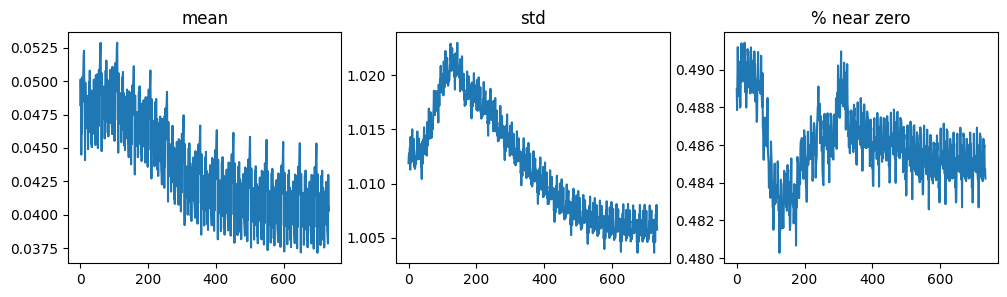

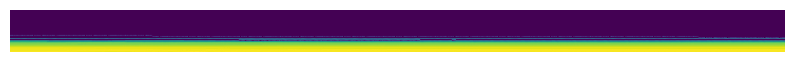

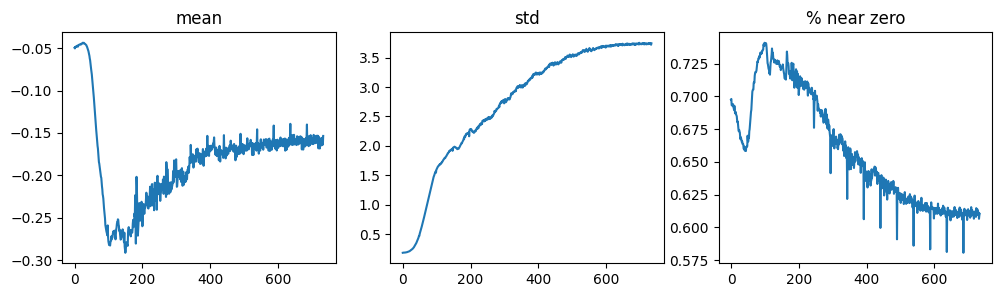

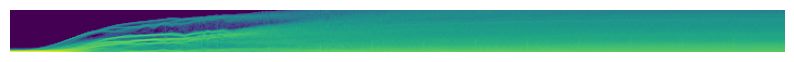

In [63]:
learn.activation_stats.plot_layer_stats(0)
learn.activation_stats.color_dim(0)
learn.activation_stats.plot_layer_stats(-1)
learn.activation_stats.color_dim(-1)

# Building a LSTM From Scratch

Understanding the effect of passing through sigmoid and tanh

In [139]:
x = torch.randn(5)
l1 = nn.Linear(5, 10)
x

tensor([ 0.6248, -2.0750,  1.0938, -0.3075,  0.9561])

In [140]:
inp1 = torch.sigmoid(x)
inp1

tensor([0.6513, 0.1116, 0.7491, 0.4237, 0.7223])

In [141]:
inp2 = torch.tanh(inp1)
inp2

tensor([0.5726, 0.1111, 0.6346, 0.4001, 0.6184])

In [ ]:
class LSTMCell(Module):
    def __init__(self, n_inputs, n_hiddens):
        self.forget_gate    = nn.Linear(n_inputs + n_hiddens, n_hiddens)
        self.input_gate     = nn.Linear(n_inputs + n_hiddens, n_hiddens)
        self.cell_gate      = nn.Linear(n_inputs + n_hiddens, n_hiddens)
        self.output_gate    = nn.Linear(n_inputs + n_hiddens, n_hiddens)

    def forward(self, input, state):
        # get previous state?
        h,cell_state = state

        # concatenate previous thing and new input 
        h = torch.cat([h, input], dim=1)

        # *****************
        # compute 4 gates
        # *****************

        # 1. Forget Gate - Mask to determine how much of the inputish do we want to keep?
        # decide how much to keep = [0, 0.3, 0.5, 0.7, 1], etc.
        # remember some! forget some!
        cell_state *= torch.sigmoid(self.forget_gate(h))

        # 2. Input Gate And 3. Cell Gate
        # sigmoid   = how much of the input do you want, 10%, 20%?
        # tanh      = among the cell gate values, arrange them, create meaning
        cell_state = cell_state + torch.sigmoid(self.input_gate(h)) * torch.tanh(self.cell_gate(h))

        # 4. Update hidden state from Output Gate
        # sigmoid   = how much of the output do you want, 50%, 80%?
        # tanh      = among the cell STATE values, arrange them, create meaning
        h = torch.sigmoid(self.output_gate(h)) * torch.tanh(cell_state)
        return h, (h, cell_state)

# Fixing Exploding or Disappearing Activations With LSTMs

In [64]:
# remember this shape, it's gonna be the output of the internal LSTM
torch.zeros(2, bs, 50).shape

torch.Size([2, 64, 50])

In [67]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, lstm_n_layers):
        self.inputs_to_embeds = nn.Embedding(vocab_sz, n_hidden)
        # batch_first because..?
        self.rnn = nn.LSTM(n_hidden, n_hidden, lstm_n_layers, batch_first=True)
        self.hidden_to_output = nn.Linear(n_hidden, vocab_sz)

        # self.h = [torch.Size([2, 64, 50]), torch.Size([2, 64, 50])]
        self.h = [torch.zeros(lstm_n_layers, bs, n_hidden) for _ in range(2)] # 2 because lstm requires 2 hidden states

    def forward(self, x):
        # res = ?
        res,lstm_hidden_states = self.rnn(self.inputs_to_embeds(x), self.h)
        self.h = [h_.detach() for h_ in lstm_hidden_states]
        return self.hidden_to_output(res)

    def reset(self):
        for h in self.h: h.zero_()


model = LMModel6(len(vocab), 50, 2)
print(model)
learn = Learner(dls, model, 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=[ModelResetter,ActivationStats(with_hist=True)])
learn.fit_one_cycle(15, 1e-2)
track_results('LMModel6 - LSTM', learn.recorder.log[-2])

LMModel6(
  (inputs_to_embeds): Embedding(30, 50)
  (rnn): LSTM(50, 50, num_layers=2, batch_first=True)
  (hidden_to_output): Linear(in_features=50, out_features=30, bias=True)
)


epoch,train_loss,valid_loss,accuracy,time
0,3.153225,2.860101,0.265951,00:08
1,2.365912,1.753775,0.466309,00:07
2,1.706985,1.691177,0.482666,00:07
3,1.413896,1.781284,0.504150,00:07
4,1.211155,1.871725,0.537923,00:07
5,1.039084,1.971692,0.606201,00:07
6,0.886829,1.927024,0.668864,00:08
7,0.722746,1.938235,0.689860,00:07
8,0.558757,1.808729,0.716878,00:08
9,0.418356,1.792872,0.752034,00:08


,
LMModel3 - Stateful RNN,0.5908653736114502
LMModel4 - Sequence To Sequence RNN,0.5546061396598816
LMModel5 - Stacked RNNs,0.5524088740348816
LMModel6 - LSTM,0.7899577021598816


Looking at the training loss, we see that we are overfitting, it'a a sign that we need to do some regularization, if we want to continue training for more epochs


# Regularizing an LSTM with AWD-LSTM

Usually in other domains such as vision, we would use data augmentation to solve overfitting. But in text, it's not that common. Instead there are techniques like:
- Dropout
- activation regularization
- and temporal activation regularization 

### Bernouilli

In [68]:
a = torch.empty(5).uniform_(0, 1)
a

tensor([0.9446, 0.4416, 0.0462, 0.8045, 0.1625])

In [69]:
for _ in range (5):
    print(a.bernoulli(0.9))

tensor([1., 0., 1., 1., 1.])
tensor([1., 1., 1., 0., 0.])
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 0., 1.])
tensor([1., 1., 0., 1., 1.])


In [70]:
for _ in range (5):
    print(a.bernoulli(0.1))

tensor([1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1.])
tensor([0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1.])
tensor([0., 0., 0., 0., 0.])


In [71]:
for _ in range (5):
    print(a.bernoulli(0.5))

tensor([1., 1., 0., 1., 1.])
tensor([1., 0., 1., 0., 0.])
tensor([1., 0., 0., 0., 1.])
tensor([1., 0., 1., 1., 1.])
tensor([1., 1., 0., 1., 1.])


### Dropout Layer

1. Use bernoulli to create a mask
2. Apply the mask to the weights, thus making some weights 0
3. And... not just multiply remaining by 1 but more than 1, making their magniture more important!

In [72]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-self.p)
        print('x\t\t\t', x)
        print('mask\t\t\t', mask)
        print('mask.div(1-self.p)\t', mask.div(1-self.p))
        return x * mask.div_(1-self.p)
    
Dropout(0.5)(a)

x			 tensor([0.9446, 0.4416, 0.0462, 0.8045, 0.1625])
mask			 tensor([0., 0., 1., 1., 0.])
mask.div(1-self.p)	 tensor([0., 0., 2., 2., 0.])


tensor([0.0000, 0.0000, 0.0925, 1.6090, 0.0000])

__how does this `mask.div_` trick keep the weights magnitude?__

It's a bit different than keeping the same of the weights or the mean of the weights, we can measure the magnitude by...

In [81]:
# Define a simple input tensor
input_tensor = torch.randn(1000, 1000)

# Define dropout probability
p = 0.3

# Without dropout
output_without_dropout = input_tensor.clone()

# With dropout, multiple experiments
n_experiments = 100
outputs_with_dropout = []

outputs_with_masks = []

for _ in range(n_experiments):
    mask = input_tensor.new_full(input_tensor.shape, 1-p).bernoulli()
    output_with_mask = input_tensor * mask
    outputs_with_masks.append(output_with_mask.sum().item())

    real_mask = input_tensor.new_full(input_tensor.shape, 1-p).bernoulli().div_(1-p)
    output_with_dropout = input_tensor * real_mask
    outputs_with_dropout.append(output_with_dropout.sum().item())

    

# Calculate average output sum with dropout
average_output_with_dropout = sum(outputs_with_dropout) / n_experiments

# Calculate average output sum with mask
average_output_with_mask = sum(outputs_with_masks) / n_experiments

# Compare
print("Difference with dropout (magnitude):", abs(output_without_dropout.sum().item() - average_output_with_dropout))
print("Difference with mask only:", abs(output_without_dropout.sum().item() - average_output_with_mask))


Difference with dropout (magnitude): 60.312301940917905
Difference with mask only: 439.1952346801759


As we can see, increase the original magnitude of the remaining weights `mask.div_(1-p)`
And thus help the overall magnitude to be closer to as if we had the original weights
With the benefit of course that we now have new weights that are set to 0 and that we can use to train more

### Activation Regularization and Temporal Activation Regularization

### Putting Everything Together

In [118]:
len(text), text[:10]

(365478, 'one . two ')

We want to have sequences of 16 tokens for each row

In [119]:
sequences = [' '.join(tokens[i:i+16]) for i in range(0, len(tokens), sequence_length)]
sequences[0]

'one . two . three . four . five . six . seven . eight .'

In [120]:
df = pd.DataFrame({'text': sequences})
df

,text
0,one . two . three . four . five . six . seven . eight .
1,nine . ten . eleven . twelve . thirteen . fourteen . fifteen . sixteen .
2,seventeen . eighteen . nineteen . twenty . twenty one . twenty two . twenty three
3,. twenty four . twenty five . twenty six . twenty seven . twenty eight .
4,twenty nine . thirty . thirty one . thirty two . thirty three . thirty four
...,...
3939,eighty nine . nine thousand nine hundred ninety . nine thousand nine hundred ninety one .
3940,nine thousand nine hundred ninety two . nine thousand nine hundred ninety three . nine thousand
3941,nine hundred ninety four . nine thousand nine hundred ninety five . nine thousand nine hundred
3942,ninety six . nine thousand nine hundred ninety seven . nine thousand nine hundred ninety eight


In [121]:
dls = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_items=ColReader('text'),  # Assuming each item in your DataFrame is a text entry
    splitter=RandomSplitter(0.2)  # Randomly split the data into training and validation sets
).dataloaders(df, bs=bs, seq_len=sequence_length, drop_last=True, shuffle=False)
dls.device = None

dls.show_batch(max_n=3)
len(dls.vocab), dls.device

,text,text_
0,xxbos . six hundred thirty . six hundred thirty one . six hundred thirty two .,. six hundred thirty . six hundred thirty one . six hundred thirty two . six
1,two hundred ninety four . four thousand two hundred ninety five . xxbos nine thousand nine,hundred ninety four . four thousand two hundred ninety five . xxbos nine thousand nine hundred
2,. seven thousand four hundred twenty nine xxbos eight hundred eleven . one thousand eight hundred,seven thousand four hundred twenty nine xxbos eight hundred eleven . one thousand eight hundred twelve


(40, None)

VERIFY LAST BATCH

In [122]:
def show_last_batch(dls):
    last_batch = None
    for batch in dls.train:
        last_batch = batch
    x, y = last_batch

    # Get the vocabulary from the DataLoader
    vocab = dls.vocab

    # Function to convert indices to text
    def indices_to_text(indices):
        return ' '.join([vocab[it] for it in indices])

    # Convert and print the first input sequence in the batch
    print(indices_to_text(x[0]), ' | ', indices_to_text(x[1]))

show_last_batch(dls)
# last batch doesn't seem right... what to do?

thousand xxbos three . four thousand  |  seven thousand four hundred twenty eight


In [128]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p, bs=64):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.bs = bs
        self.n_hidden,self.n_layers = n_hidden,n_layers
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        if self.h is None or self.h[0].size(1) != x.size(0):
            # Adjust hidden state size based on current batch size
            self.reset_hidden(x.size(0))
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset_hidden(self, bs):
        self.bs = bs
        # Reset hidden state to zeros with appropriate batch size
        self.h = (torch.zeros(self.n_layers, self.bs, self.n_hidden),
                  torch.zeros(self.n_layers, self.bs, self.n_hidden))
    
    def reset(self): 
        for h in self.h: h.zero_()

# our model seems not able to overfit, no need of big dropout value for now
model = LMModel7(len(dls.vocab), 80, 4, 0.4)
print(model)
# learn = Learner(dls, model, 
#                 loss_func=CrossEntropyLossFlat(), 
#                 metrics=accuracy, cbs=[ModelResetter,ActivationStats(with_hist=True),RNNRegularizer(alpha=2, beta=1)]).to_fp16()

# If you use TextLearner, but you will have to implement get_preds and predict yourself
learn = LMLearner(dls, model,
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, Perplexity()],
                    cbs=[ActivationStats(with_hist=True)])

gc.collect()
# learn.lr_find()
# our model seems not able to overfit, no need of big weight decay value for now
learn.fit_one_cycle(15, 1e-2, wd=0.1)
track_results('LMModel7 - LSTM - Dropout/AR/TR', learn.recorder.log[-3])

LMModel7(
  (i_h): Embedding(40, 80)
  (rnn): LSTM(80, 80, num_layers=4, batch_first=True)
  (drop): Dropout(p=0.4, inplace=False)
  (h_o): Linear(in_features=80, out_features=40, bias=True)
)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.995922,2.450656,0.351423,11.595953,00:06
1,2.302832,1.941079,0.379813,6.966263,00:06
2,1.863473,1.756165,0.456264,5.790191,00:06
3,1.617806,1.518527,0.478167,4.565497,00:06
4,1.451983,1.417245,0.487723,4.125739,00:07
5,1.321320,1.326928,0.531250,3.769444,00:06
6,1.212605,1.112487,0.590890,3.041914,00:07
7,1.101270,1.099972,0.602539,3.004081,00:07
8,1.019222,0.977569,0.642299,2.657986,00:06
9,0.928289,0.973586,0.649065,2.647420,00:06


,
LMModel7 - LSTM - Dropout/AR/TR,0.7158203125


In [186]:
learn.show_results(max_n=3)

,input,target,pred
0,xxbos thousand three hundred twenty eight . eight thousand three hundred twenty nine . eight thousand,thousand three hundred twenty eight . eight thousand three hundred twenty nine . eight thousand three,. one hundred thirty three . three thousand three hundred twenty nine . eight thousand three
1,nine . four thousand two hundred fifty . four thousand two hundred fifty one . xxbos,. four thousand two hundred fifty . four thousand two hundred fifty one . xxbos thousand,thousand three thousand seven hundred thirty . four thousand xxbos xxbos xxbos xxbos xxbos xxbos .
2,thousand six hundred forty one . three thousand six hundred forty two . xxbos nine thousand,six hundred forty one . three thousand six hundred forty two . xxbos nine thousand three,five hundred eighty three . xxbos thousand xxbos hundred forty two . xxbos . hundred one


In [187]:
def predict_next(txt, learn):
    N_WORDS = 16
    N_SENTENCES = 5
    preds = [learn.predict(txt, N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    print("\n".join(preds))

predict_next('one', learn)

one . nine thousand seven hundred thirteen . nine thousand seven hundred fourteen . nine thousand
one hundred thirty . seven thousand one hundred thirty one . seven thousand one hundred thirty
one thousand two hundred seventy three . one thousand two hundred seventy four . one thousand
one . two thousand six hundred sixty two . two thousand six hundred sixty three .
one thousand seven hundred sixty three . one thousand seven hundred sixty four . one three


# Comparing our model with fastai solution on numbers dataset

In [193]:
learn = language_model_learner(
    dls, AWD_LSTM, drop_mult=0.1,
    metrics=[accuracy, Perplexity()])
# learn.lr_find(suggest_funcs=(slide,valley))
print(learn.model)
# learn.lr_find()
learn.fit_one_cycle(15, 1e-2, wd=0.1)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(40, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(40, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=40, bias=True)
    (output_dp): RNNDropout()
  )
)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.729809,3.851745,0.114118,47.075153,00:33
1,3.494388,2.196289,0.343959,8.991582,00:32
2,2.687732,1.880692,0.411551,6.558039,00:31
3,2.268278,1.765584,0.419852,5.844984,00:31
4,2.027504,1.714239,0.428362,5.552448,00:33
5,1.882215,1.674678,0.438616,5.337076,00:32
6,1.790388,1.657169,0.446010,5.244440,00:33
7,1.722497,1.615540,0.460519,5.030602,00:33
8,1.671582,1.592613,0.469169,4.916578,00:33
9,1.637526,1.565410,0.475377,4.784638,00:32


__What's going on?__
- the model is too big to learn from such a small dataset? hidden = 400!
- or maybe need to be trained longer?

In [190]:
predict_next('one', learn)

one hundred eighty two . nine hundred eighty nine thousand four hundred fourteen Fifteen
one ten hundred forty four . five hundred forty nine . five hundred forty seven . nine


# IMDB Dataset

### Our Model

In [196]:
path = untar_data(URLs.IMDB)
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls = DataBlock(
     blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb,
    splitter=RandomSplitter(0.2)
).dataloaders(path, path=path, bs=128, seq_len=80, drop_last=True, shuffle=False)

dls.device = None

dls.show_batch(max_n=3)
len(dls.vocab)

,text,text_
0,"xxbos xxmaj this is the best pilot for xxup st out there ! xxmaj let 's just say that this is just the pilot , and it seems a little time passed before the shot the second episode because it has a completely different feel that will become the norm for the rest of the series . xxmaj avery xxmaj brooks will tend to over - act but this becomes more balanced as the series progresses . xxmaj finally we","xxmaj this is the best pilot for xxup st out there ! xxmaj let 's just say that this is just the pilot , and it seems a little time passed before the shot the second episode because it has a completely different feel that will become the norm for the rest of the series . xxmaj avery xxmaj brooks will tend to over - act but this becomes more balanced as the series progresses . xxmaj finally we get"
1,"hang around for the next ninety or so minutes will depend on your propensity for xxunk . xxbos xxmaj this is on my xxup tv right now … but only long enough for me to finish panning it in this comment . xxmaj the previous comment let me know that this movie will not get any better , no matter how much i hope and pray . i will concur this movie is a colossal waste of my time ,","around for the next ninety or so minutes will depend on your propensity for xxunk . xxbos xxmaj this is on my xxup tv right now … but only long enough for me to finish panning it in this comment . xxmaj the previous comment let me know that this movie will not get any better , no matter how much i hope and pray . i will concur this movie is a colossal waste of my time , and"
2,. xxmaj bravo and bravo ! \n\n xxmaj director xxmaj christopher xxmaj xxunk directed this episode and what a talented and passionate guy he is . xxmaj stunning dying - scenes of xxmaj charlie in a place that exists in his memory / soul / heart layered with voices from the xxup er . xxmaj bravo too . \n\n xxmaj of course xxmaj liotta deserves a major guest role in such a good series and not to have waltz in,xxmaj bravo and bravo ! \n\n xxmaj director xxmaj christopher xxmaj xxunk directed this episode and what a talented and passionate guy he is . xxmaj stunning dying - scenes of xxmaj charlie in a place that exists in his memory / soul / heart layered with voices from the xxup er . xxmaj bravo too . \n\n xxmaj of course xxmaj liotta deserves a major guest role in such a good series and not to have waltz in for


60008

In [ ]:
model = LMModel7(len(dls.vocab), 80, 2, 0.4, bs=dls.bs)
print(model)

learn = LMLearner(dls.to('cuda'),model,
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, Perplexity()],
                    cbs=[ModelResetter,ActivationStats(with_hist=True)]).fp16()
gc.collect()
# learn.lr_find(suggest_funcs=(slide, valley))
learn.fit_one_cycle(15, 1e-2, wd=0.1)

In [ ]:
predict_next('i love this movie', learn)

### Fastai Model

In [ ]:
learn = language_model_learner(
    dls.to('cuda'), AWD_LSTM, drop_mult=0.1,
    metrics=[accuracy, Perplexity()])
# learn.lr_find(suggest_funcs=(slide,valley))
print(learn.model)
# learn.lr_find()
learn.fit_one_cycle(15, 1e-2, wd=0.1).to_fp16()

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60008, bias=True)
    (output_dp): RNNDropout()
  )
)


epoch,train_loss,valid_loss,accuracy,perplexity,time


In [ ]:
predict_next('i love this movie', learn)